### Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [1]:
import numpy as np
import torch
from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    q3ab_save_results,
    q3c_save_results,
    
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)

/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.set_default_device(device)
print(device)

cuda


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset
import pickle
import time
import matplotlib.pyplot as plt
import os

In [4]:
import torch.utils.cpp_extension
torch.utils.cpp_extension.CUDA_HOME

':/usr/local/cuda-11.2'

In [5]:
import torch
torch.version.cuda

'11.3'

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


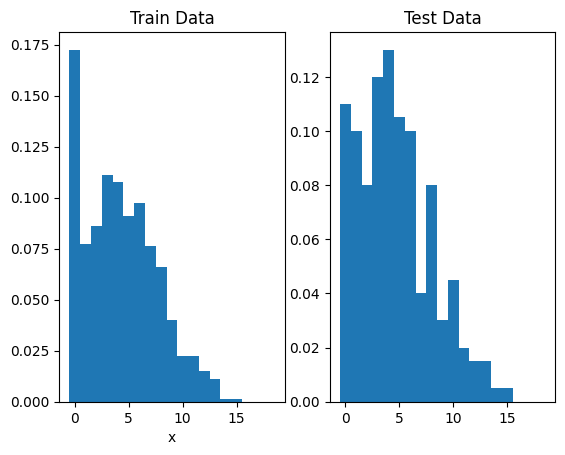

Dataset 2


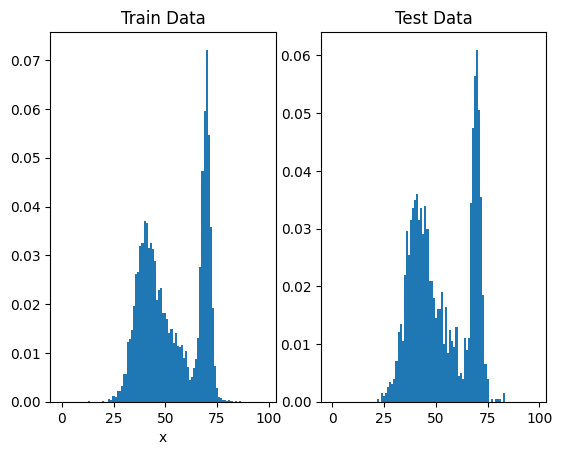

In [6]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^{d}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




In [7]:
@torch.no_grad()
def test_loss(model, test_loader) -> float :
  model.eval()
  loss, count = 0, 0
  with torch.no_grad():
    for x in test_loader:
      x = x.to(device)
      loss += model.loss(x).item()
      count += 1
  return loss / count


Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [8]:

def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  class model(nn.Module):
    def __init__(self, d):
      super().__init__()
      self.thetas = nn.Parameter(torch.zeros(d))

    def forward(self, x):
      return x

    def loss(self, x):
      batch_thetas = self.thetas.expand(len(x), -1)
      return F.cross_entropy(batch_thetas, x)
    @torch.no_grad()
    def distribution(self) -> np.ndarray:
      return F.softmax(self.thetas, dim=0).cpu().numpy()

  lr, epochs, batch_size = 0.4, 30, 128
  model = model(d).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr)
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
  train_losses, test_losses = [], []

  for epoch in range(epochs):
    model.train()
    for x in train_loader:
      optimizer.zero_grad()
      loss = model.loss(x.to(device))
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
    test_losses.append(test_loss(model, test_loader))

  distribution = model.distribution()
  print(distribution[:2])
  print(model.thetas[:2])
  return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



[0.16701403 0.0695264 ]
tensor([1.7553, 0.8789], device='cuda:0', grad_fn=<SliceBackward0>)
Final Test Loss: 2.5867


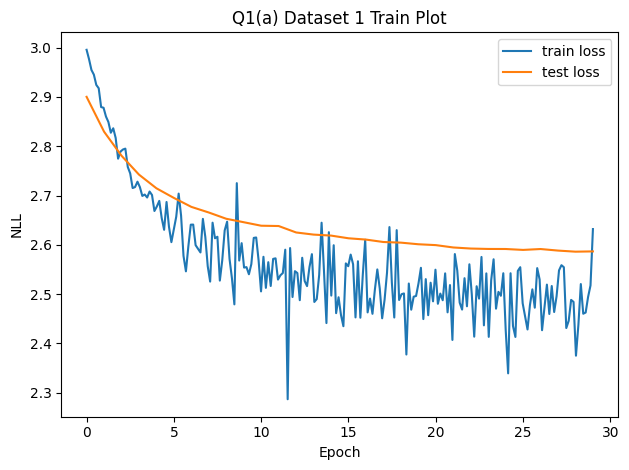

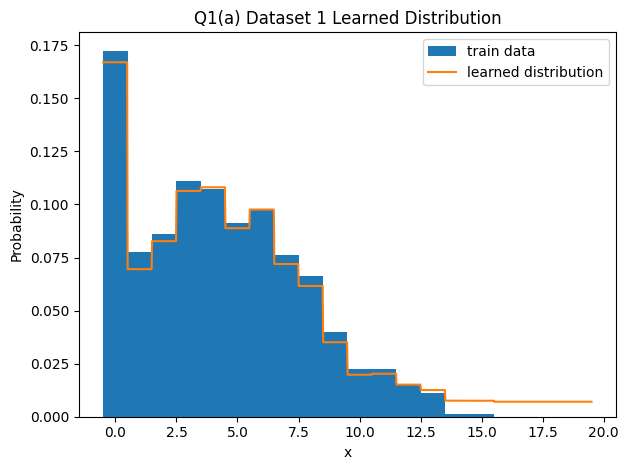

In [9]:
q1_save_results(1, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

In [10]:
q1_save_results(2, 'a', q1_a)

我们本身是要拟合一个函数，而这个函数就是对于数据的概率分布。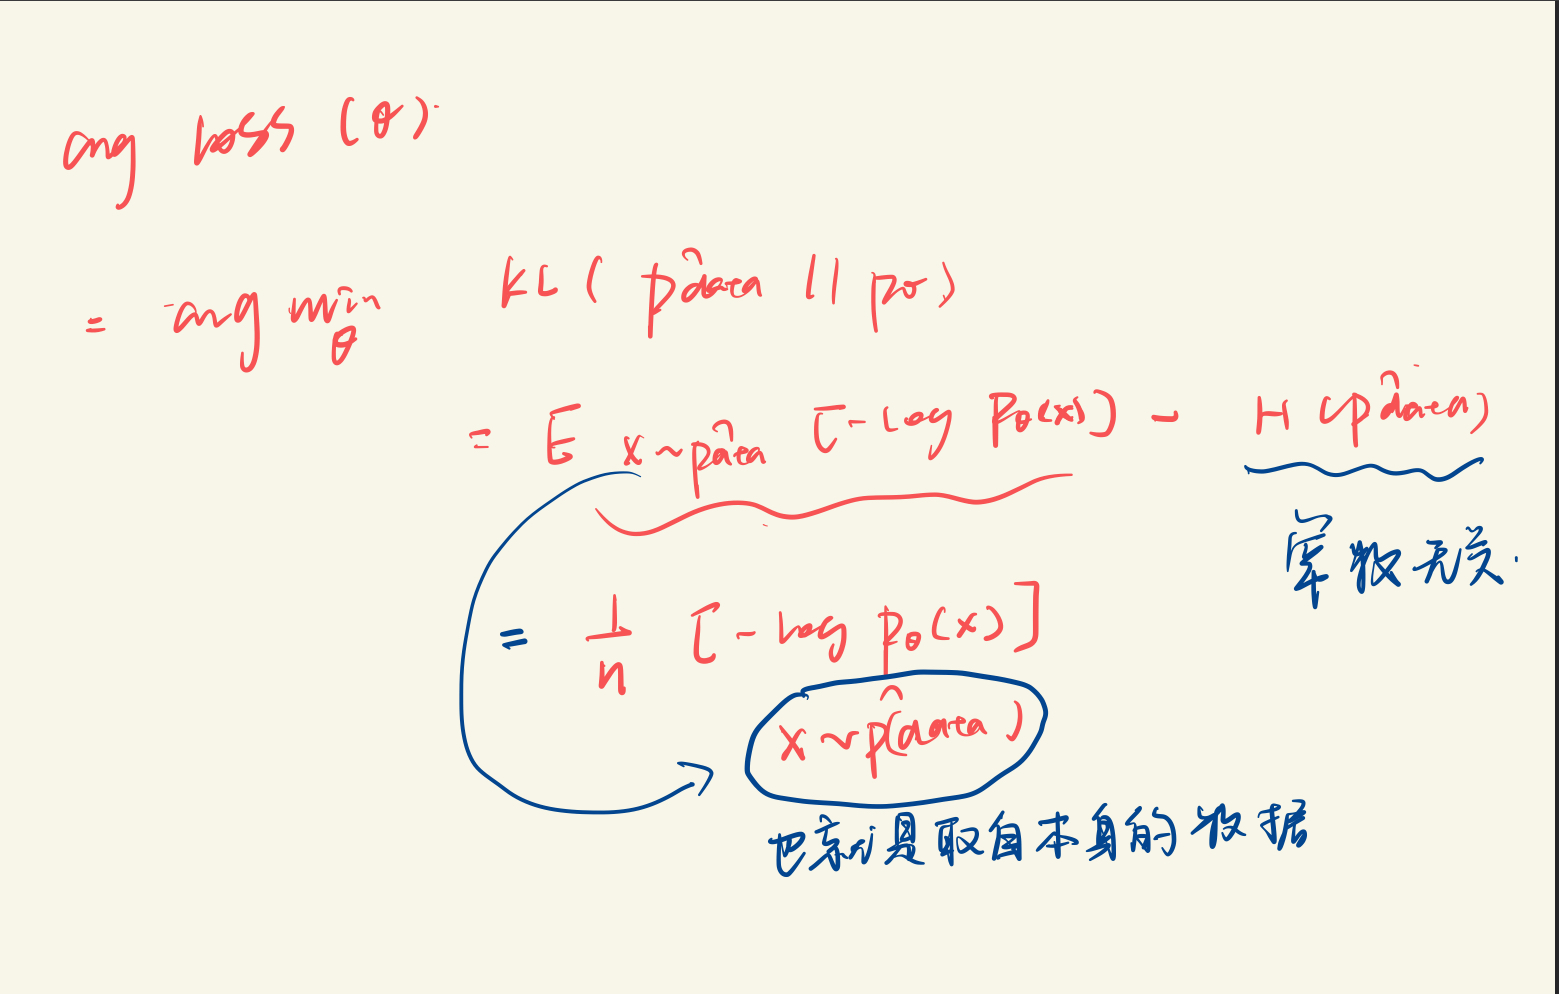

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:


def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """

  class MixedLogistics(nn.Module):
    def __init__(self, d):
      super().__init__()
      self.w = nn.Parameter(torch.rand(4))
      # TODO
      self.u = nn.Parameter(torch.rand(4))
      self.log_scales = nn.Parameter(torch.rand(4))
      self.d = d
      self.eps = 1e-5

    def loss(self, x):
      x = self.forward(x)
      return -torch.log(x).mean()

    def forward(self, x):
      scales = torch.exp(self.log_scales)
      P1 = torch.sigmoid((x.unsqueeze(1) + 0.5 - self.u) / scales)
      P2 = torch.sigmoid((x.unsqueeze(1) - 0.5 - self.u) / scales)
      res = P1 - P2

      zero_case = torch.sigmoid((0.5 - self.u) / scales)
      up_case = 1 - torch.sigmoid((99 - 0.5 - self.u) / scales)

      res[x == 0] = zero_case
      res[x == 99] = up_case

      # TODO
      ans = res @ torch.softmax(self.w, dim = 0)
      # important!!!!! avoid log(0)
      return ans + self.eps

    #TODO
    @torch.no_grad()
    def distribuition(self) -> np.ndarray:
      x = torch.arange(0, self.d).float().to(device)
      x = self.forward(x)
      norm = x.sum()
      return (x/norm).cpu().numpy()

  if dset_id == 1:
    lr, epochs, batch_size = 0.03, 20, 64
  elif dset_id == 2:
    lr, epochs, batch_size = 0.1, 10, 64

  model = MixedLogistics(d).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
  train_losses, test_losses = [], []


  for epoch in range(epochs):
    model.train()
    for x in train_loader:
      x = x.to(device)
      optimizer.zero_grad()
      loss = model.loss(x)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
    test_losses.append(test_loss(model, test_loader))
  distribution = model.distribuition()
  return train_losses, test_losses, distribution

In [ ]:
q1_save_results(1, 'b', q1_b)

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN models on the shapes dataset and MNIST. In addition, we will extend to modeling colored datasets.

Run the cell below to visualize the two datasets binary datasets

In [ ]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network.

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

**该网络实现的功能是推算出当前点为像素值为1的概率**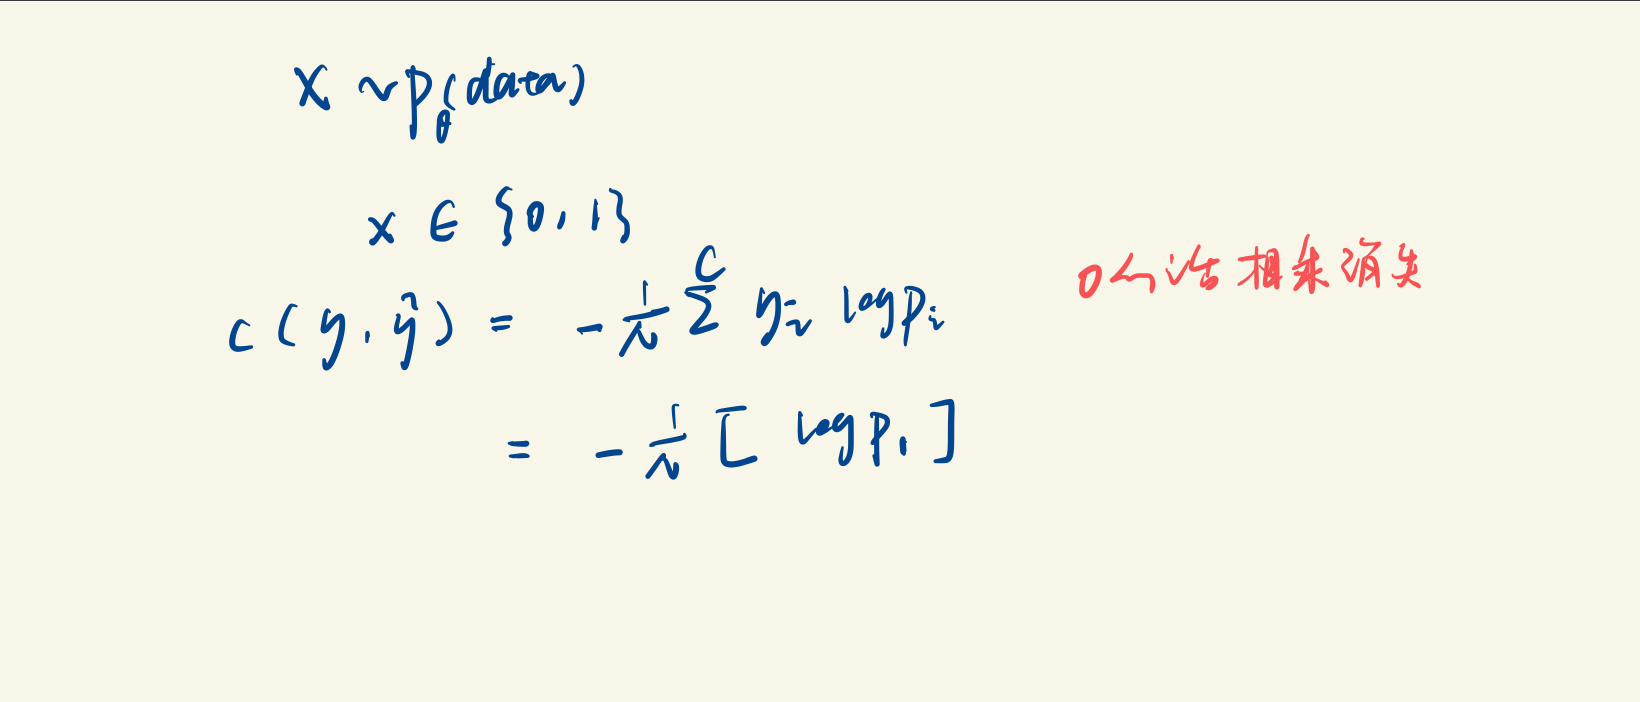

In [ ]:
#此为手写版本
class MonoMaskedCon2d(nn.Conv2d):
  def __init__(self, in_channels, out_channels, kernel_size, mask_type):


    assert mask_type in ['A', 'B']
    assert kernel_size % 2 == 1

    
    super().__init__(in_channels, out_channels, kernel_size)
    self.register_buffer('mask', torch.zeros_like(self.weight))
    middle = kernel_size // 2
    self.mask[:, :, :middle, :] = 1
    self.mask[:, :, middle, :middle + (mask_type == 'B')] = 1

    self.padding2 = nn.ConstantPad2d((kernel_size - 1, 0, kernel_size - 1, 0), 0)


  def forward(self, x):

    '''x : (B, 1, H, W)'''
    
    x = self.padding2(x)

    self.weight.data *= self.mask
    
    return super().forward(x)

co = MonoMaskedCon2d(1, 1, 3, 'B')
x = torch.randn((3, 1, 10, 10))
print(co(x).shape)


In [ ]:
# 此为"same"版本
class MonoMaskedCon2d(nn.Conv2d):
  def __init__(self, input_channels, output_channels, kernel_size, mask_type, padding='same'):
    '''
    A monocolour masked convolutional layer.
    mask_type: 'A' or 'B'.
    kernel_size: supposed to be an odd number.
    '''
    assert mask_type in ['A', 'B'], "mask_type must be 'A' or 'B'"
    assert kernel_size % 2 == 1, "kernel_size must be an odd number"
    super().__init__(input_channels, output_channels, kernel_size, padding=padding)
    self.register_buffer('mask', torch.zeros_like(self.weight))
    middle = kernel_size // 2
    self.mask[:, :, :middle, :] = 1 # mask the pixels above the center pixel
    self.mask[:, :, middle, :middle + (mask_type == 'B')] = 1 # mask the pixels to the left of the center pixel, if the mask_type is 'B', additionally mask the center pixel

  def forward(self, x):
    '''x: (B, 1, H, W)'''
    self.weight.data *= self.mask
    return super().forward(x)

In [ ]:
#此为手写版本
class MonoMaskedCon2d(nn.Conv2d):
  def __init__(self, in_channels, out_channels, kernel_size, mask_type):


    assert mask_type in ['A', 'B']
    assert kernel_size % 2 == 1

    
    super().__init__(in_channels, out_channels, kernel_size)
    self.register_buffer('mask', torch.zeros_like(self.weight))
    middle = kernel_size // 2
    self.mask[:, :, :middle, :] = 1
    self.mask[:, :, middle, :middle + (mask_type == 'B')] = 1

    self.padding2 = nn.ConstantPad2d((middle, middle, middle, middle), 0)


  def forward(self, x):

    '''x : (B, 1, H, W)'''
    
    x = self.padding2(x)

    self.weight.data *= self.mask
    
    return super().forward(x)
    

class MonoPixelCNN(nn.Module):
  def __init__(self, num_filters, image_shape):
    super().__init__()
    self.image_shape = image_shape

    # a 7*7 A, 5 7*7 B, 2 1*1 B
    self.layers = nn.Sequential(
      MonoMaskedCon2d(1, num_filters, kernel_size = 7, mask_type = 'A'),
      nn.ReLU(),MonoMaskedCon2d(num_filters, num_filters, kernel_size = 7, mask_type = 'B'),
      nn.ReLU(),MonoMaskedCon2d(num_filters, num_filters, kernel_size = 7, mask_type = 'B'),
      nn.ReLU(),MonoMaskedCon2d(num_filters, num_filters, kernel_size = 7, mask_type = 'B'),
      nn.ReLU(),MonoMaskedCon2d(num_filters, num_filters, kernel_size = 7, mask_type = 'B'),
      nn.ReLU(),MonoMaskedCon2d(num_filters, num_filters, kernel_size = 7, mask_type = 'B'),
      nn.ReLU(),MonoMaskedCon2d(num_filters, num_filters, kernel_size = 1, mask_type = 'B'),
      nn.ReLU(),MonoMaskedCon2d(num_filters, 1, kernel_size = 1, mask_type = 'B')
    )


  def forward(self, x):
    return self.layers(x)


  def loss(self, x):
    logits = self.forward(x)
    return F.binary_cross_entropy_with_logits(logits, x)

  @torch.no_grad()
  def samples(self, N):
    H, W = self.image_shape
    num_dims = H * W
    samples = torch.zeros(N, 1, H, W).to(device)

    for i in range(num_dims):
      logits = self.forward(samples.to(torch.float32)).flatten(1)[:, i]
      probs = torch.sigmoid(logits)
      samples.flatten(1)[:, i] = torch.bernoulli(probs)

    print(samples)
    return samples



In [ ]:
device

In [ ]:
import os

def q2_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  train_data = train_data.reshape(-1, 1, *image_shape).astype(np.float32)
  test_data = test_data.reshape(-1, 1, *image_shape).astype(np.float32)

  print(image_shape, train_data.shape)


  # des == 1： lr, epochs, batch_size, num_filters = 1e-3, 10, 128, 64
  if dset_id == 1:
    lr, epochs, batch_size, num_filters = 1e-3, 20, 256, 64
  elif dset_id == 2:
    lr, epochs, batch_size, num_filters = 1e-3, 10, 128, 64

  model = MonoPixelCNN(num_filters = num_filters, image_shape = image_shape).to(device)
  optimizer = optim.Adam(model.parameters(), lr = lr)


  train_loaders = DataLoader(train_data, batch_size = batch_size, shuffle = True)
  test_loaders = DataLoader(test_data, batch_size = batch_size, shuffle = False)

  train_losses, test_losses = [], [test_loss(model, test_loaders)]
  samples = []

  # model.load_state_dict(torch.load(os.path.join(
  #           "Checkpoints", "ckpt_10_.pt"), map_location=device))

  for epoch in range(epochs):
    model.train()
    
    print(f"epoch : {epoch}", end = "   ")
    
    for batch, x in enumerate(train_loaders):
      
    test_losses.append(test_loss(model, test_loaders))
    print(f"loss : {test_losses[-1]}")

	X = x.to(device)
	optimizer.zero_grad()
	loss = model.loss(X)
	loss.backward()
	optimizer.step()
	train_losses.append(loss.item())
    
  samples = model.samples(100).cpu()	
  samples = samples.reshape(100, *image_shape, 1)
  
  torch.save(model.state_dict(), os.path.join(
        'Checkpoints', 'ckpt_' + "q2a" + "_.pt"))
  
  return np.array(train_losses), np.array(test_losses), np.array(samples)

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



(20, 20) (10479, 1, 20, 20)
epoch : 0   loss : 0.20246233294407526
epoch : 1   loss : 0.15093284514215258
epoch : 2   loss : 0.13831218828757605
epoch : 3   loss : 0.12752835328380266
epoch : 4   loss : 0.11393839741746585
epoch : 5   loss : 0.10250932764675882
epoch : 6   loss : 0.09583320923977429
epoch : 7   loss : 0.07897087724672423
epoch : 8   loss : 0.07410804761780633
epoch : 9   loss : 0.07249738400181134
epoch : 10   loss : 0.06507216766476631
epoch : 11   loss : 0.06189114476243655
epoch : 12   loss : 0.06429435705973043
epoch : 13   loss : 0.05840530329280429
epoch : 14   loss : 0.05652383549345864
epoch : 15   loss : 0.05324553760389487
epoch : 16   loss : 0.051925900081793465
epoch : 17   loss : 0.04922104254364967
epoch : 18   loss : 0.04966489411890507
epoch : 19   loss : 0.046527397301461965
tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.

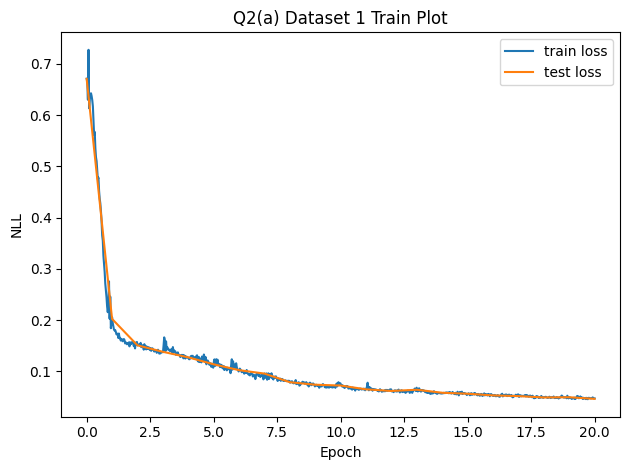

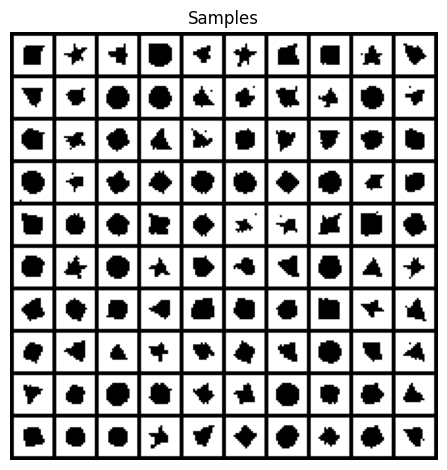

In [ ]:
q2a_save_results(1, q2_a)



In [ ]:
q2a_save_results(2, q2_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

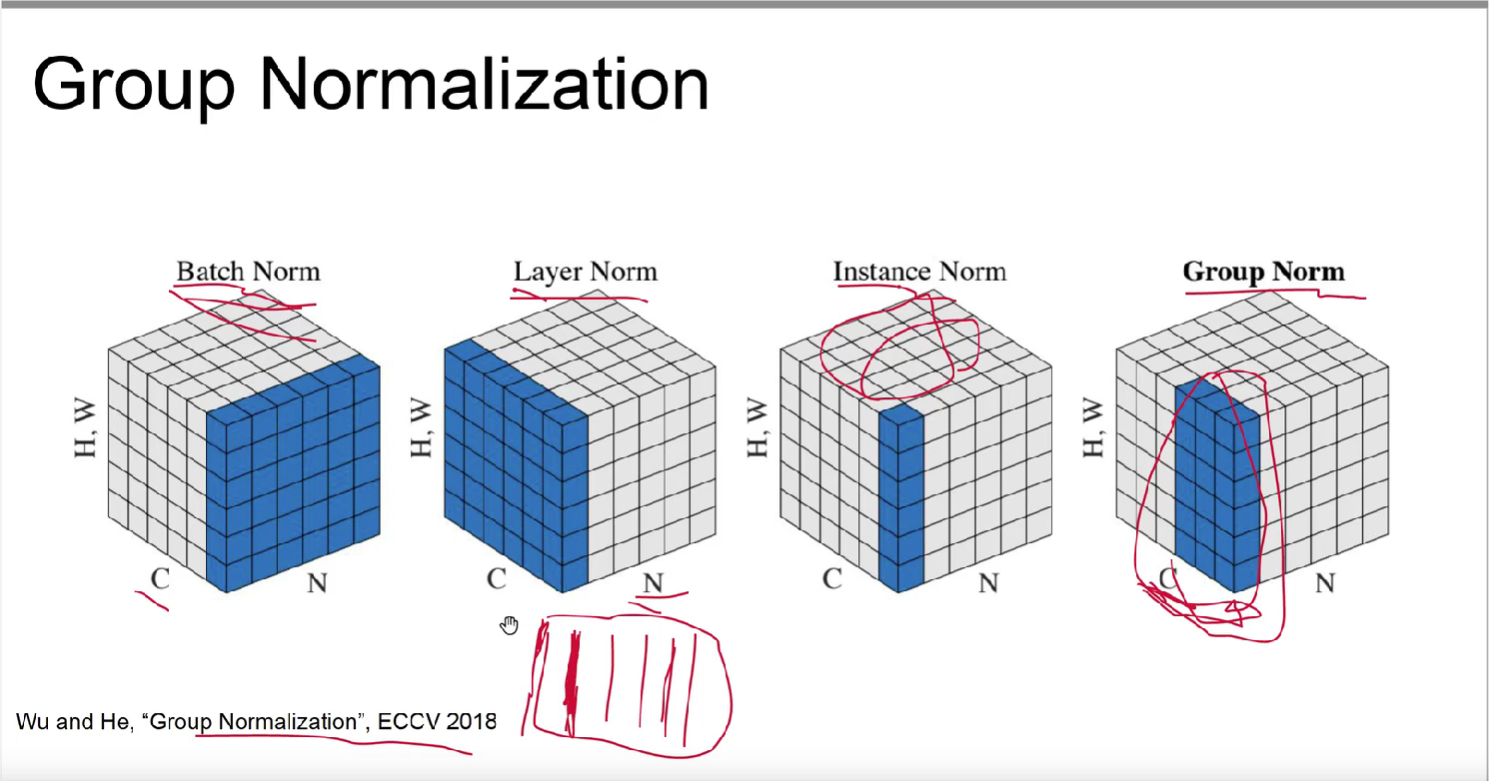

In [ ]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



In [ ]:
class MaskedConv2d(nn.Conv2d):
  def __init__(self, input_channels, output_channels, kernel_size, mask_type, padding = 'same'):

    assert mask_type in ['A', 'B']
    assert kernel_size % 2 == 1
    super().__init__(input_channels, output_channels, kernel_size, padding = padding)
    self.register_buffer('mask', torch.zeros_like(self.weight))

    middle = kernel_size // 2
    self.mask[:, :, :middle, :] = 1
    self.mask[:, :, middle, : middle + (mask_type == 'B')] = 1

  def forward(self, x):

    self.weight.data *= self.mask
    return super().forward(x)

class ResidualBlock(nn.Module):
  '''
   input: (B, num_filters, H, W)
   output: (B, num_filters, H, W)
  '''
  def __init__(self, num_filters):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ReLU(), MaskedConv2d(num_filters, num_filters // 2, 1, 'B'),
        nn.ReLU(), MaskedConv2d(num_filters // 2, num_filters // 2, 7, 'B'),
        nn.ReLU(), MaskedConv2d(num_filters // 2, num_filters, 1, 'B'),
    )

  def forward(self, x):
    return x + self.layers(x)

class ChannelsLayerNorm(nn.LayerNorm):
  '''LayerNorm will not violate the autoregressive property'''
  '''因为不同层之间相对独立，所以只以c这个维度进行归一化不会使得不同的H*W受到影响，从而保证了自回归的性质'''
  def __init__(self, normalized_shape, eps = 1e-5, elementwise_affine = True):
    super(ChannelsLayerNorm, self).__init__(normalized_shape, eps, elementwise_affine)

  def forward(self, x):
    x_permuted = x.permute(0, 2, 3, 1).contiguous()
    y_permuted = super(ChannelsLayerNorm, self).forward(x_permuted)
    y = y_permuted.permute(0, 3, 1, 2).contiguous()
    return y

class RGBPiexlCNN(nn.Module):

  def __init__(self, num_filters, image_shape):
    super().__init__()
    self.image_shape = image_shape
    self.layers = nn.ModuleList()
    self.layers.extend([MaskedConv2d(3, 2 * num_filters, kernel_size = 7, mask_type = 'A')])
    for _ in range(8):
      self.layers.extend([ResidualBlock(2 * num_filters), ChannelsLayerNorm(2 * num_filters)])
    self.layers.extend([nn.ReLU(), MaskedConv2d(2 * num_filters, 2 * num_filters, kernel_size = 1, mask_type = 'B'),
               nn.ReLU(), MaskedConv2d(2 * num_filters, 12, kernel_size = 1, mask_type = 'B')])

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def loss(self, x):
    '''X : (B, 3, H, W)'''
    logits = self.forward(x)
    B, C, H, W = logits.shape
    logits = logits.reshape(B * 3, C // 3, -1)
    labels = x.reshape(B * 3, -1).long()
    return F.cross_entropy(logits, labels)

  @torch.no_grad()
  def sample(self, N):
    H, W, C = self.image_shape
    num_dims = H * W
    samples = torch.zeros(N, 3, H, W).to(device)

    for i in range(num_dims):
      logits = self.forward(samples) # (B, 12, H, W)
      logits_i = logits.reshape(3 * N, 4, H * W)[:, :, i] # (B * 3, 4, i)
      probs_i = F.softmax(logits_i, dim = 1) # (B * 3, 4, i)
      predict = torch.multinomial(probs_i, 1) # (B * 3, 1, i)
      samples.reshape(3 * N, H * W)[:, i] = predict.squeeze()
    return samples.long()


Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32)
  test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32)
  print(image_shape)
  if dset_id == 1:
    lr, epochs, batch_size, num_filters = 3e-4, 20, 128, 120
  elif dset_id == 2:
    lr, epochs, batch_size, num_filters = 3e-4, 15, 64, 120

  model = RGBPiexlCNN(num_filters, image_shape).to(device)
  optimizer = optim.Adam(model.parameters(), lr = lr)
  train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
  test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

  
  train_losses, test_losses, samples =[], [test_loss(model, test_loader)], []

  
  for epoch in range(epochs):

    print(f'epoch is {epoch}')
    model.train()
    
    for batch, x in enumerate(train_loader):
      x = x.to(device)
      optimizer.zero_grad()
      loss = model.loss(x)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
    

    test_losses.append(test_loss(model, test_loader))

  samples = model.sample(100).cpu()
  samples = samples.permute(0, 2, 3, 1)

  return np.array(train_losses), np.array(test_losses), np.array(samples)

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



In [ ]:
q2b_save_results(1, 'b', q2_b)

In [ ]:
q2b_save_results(2, 'b', q2_b)

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer).

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
## Part (a) Autoregressive Transformer on Shapes and MNIST <a class="anchor"  id="q3a"></a>
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer).

Some additional notes about your transformer implementation:
 * iGPT uses *learned positional encodings*. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a *cosine learning rate decay*.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
## Part (a) Autoregressive Transformer on Shapes and MNIST <a class="anchor"  id="q3a"></a>
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer).

Some additional notes about your transformer implementation:
 * iGPT uses *learned positional encodings*. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a *cosine learning rate decay*.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

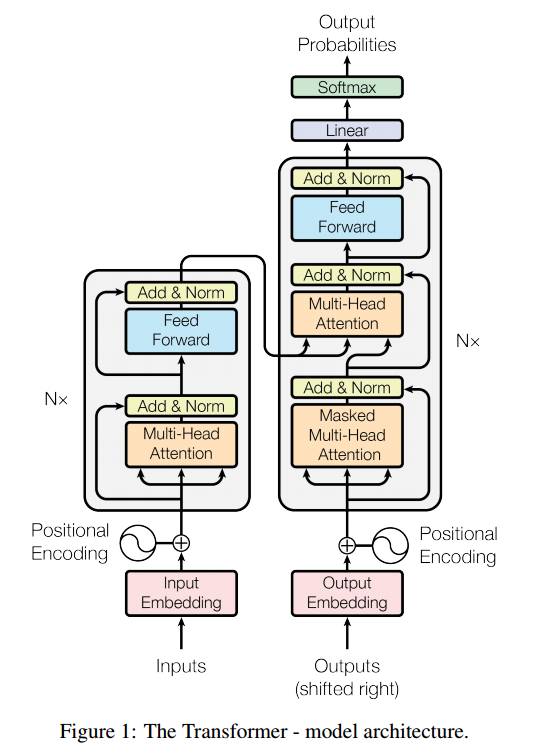


We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 100 samples from the final trained model




We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 100 samples from the final trained model


We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [ ]:
class Embedding(nn.Module):
    def __init__(self,  L, vocal_size, dmodel):
        super().__init__()
        self.L = L
        self.vocal_size = vocal_size
        self.embedding = nn.Embedding(vocal_size, dmodel)
        self.embedding_pos = nn.Embedding(L, dmodel) #位置编码

    def forward(self, x):
        pos = torch.arange(self.L).long().to(device)
        
        pos_emb = self.embedding_pos(pos)
        
        Y = self.embedding(x) + pos_emb
 
        return Y # (B, L, dmodel)

class Attention(nn.Module):
    def __init__(self, L, dmodel, dim):
        super().__init__()
        self.q = nn.Linear(dmodel, dim)
        self.k = nn.Linear(dmodel, dim)
        self.v = nn.Linear(dmodel, dim)
        self.scale = dmodel ** (-0.5)
        self.register_buffer('tril', torch.tril(torch.ones((L, L))))

    def forward(self, x):

        ''' X : (B, L, dmodel)'''

        
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        W = q @ k.transpose(-1, -2) * self.scale # (B, L, L)
        W = W.masked_fill(self.tril == 0, float('-inf'))
        W = F.softmax(W, dim = -1)
        ans = W @ v
        return ans # (B, L, dim)


class MutiAttention(nn.Module):
    def __init__(self, L, dmodel, dim, n_head):
        super().__init__()
        self.layers = nn.ModuleList([Attention(L, dmodel, dim) for _ in range(n_head)])

    def forward(self, x):
        X = [layer(x) for layer in self.layers]
        return torch.cat(X, dim = -1) # (B, L, dim * n_head)


class TransformerBlock(nn.Module):
    def __init__(self, L, dmodel, dim, n_head):
        super().__init__()
        self.Attention = MutiAttention(L, dmodel, dim, n_head)
        self.norm1 = nn.LayerNorm(dmodel)
        self.norm2 = nn.LayerNorm(dmodel)
        self.mlp = nn.Sequential(nn.Linear(dmodel, dmodel), nn.GELU())

    def forward(self, x):

        '''X : (B, L, dmodel)'''

        x = self.Attention(self.norm1(x)) + x
        x = self.mlp(self.norm2(x)) + x
        return x  # (B, L, dmodel)


class iGPT(nn.Module):
    def __init__(self, L, dmodel, vocal_size, n_layer, n_head, bos):

        super().__init__()
        self.embedding = Embedding(L, vocal_size, dmodel)

        assert dmodel % n_head == 0
        self.transformer = nn.Sequential(*[TransformerBlock(L, dmodel, dmodel // n_head, n_head) for _ in range(n_layer)])
        self.fc = nn.Linear(dmodel, vocal_size)
        self.L = L
        self.dmodel = dmodel
        self.bos = bos

    def forward(self, x):

        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x)

        return x # (B, L, vocal_size)

    def loss(self, x):

        '''X : (B, L)'''
        B, L = x.shape
        X = self.forward(x) # (B, L, vocal_size)
        pred = X[:, : -1, :].reshape(B * (L - 1), -1) # (B * (L - 1), vocal_size)
        target = x[:, 1:].flatten() #(B * (L - 1))

        # print(f"pred.shape:{pred.shape}")  
        # print(f"traget.shape:{target.shape}")

        
        return F.cross_entropy(pred, target)

    @torch.no_grad()
    def sample(self, numbers):

        samples = torch.zeros((numbers, self.L)).long().to(device)
        samples[:, 0] = self.bos
        steps = self.L - 1

        for i in range(steps):
            
            prob = self.forward(samples)[:, i, : -1]
            # print(prob.shape)
            prob = F.softmax(prob, dim = -1)
            # print(torch.multinomial(prob, 1).squeeze().shape)
            # print(samples[:, i + 1].shape)
            samples[:, i + 1] = torch.multinomial(prob, 1).squeeze()   # (100)

        return samples[:, 1:] # (B,  L - 1)


def append_bos(x, bos):

    B, L = x.shape
    Bos = torch.full((B, 1), bos, dtype = torch.long)
    return torch.cat([Bos, x], dim = 1)


class iGPTDataLoader(DataLoader):
    '''将数据按照batch进行添加bos之后的DataLoader'''
    def __init__(self, data, batch_size, shuffle = True, num_workers = 4, bos = 0):
        super().__init__(data, batch_size, shuffle = shuffle, num_workers = num_workers)
        self.bos = bos

    def __iter__(self):

        for x in super().__iter__():
            yield append_bos(x, self.bos)


In [ ]:
def q3_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    image_shape: (H, W, 1), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """


    H, W, C = image_shape
    n_train_data, n_test_data = len(train_data), len(test_data)
    train_data = np.transpose(train_data, (0, 3, 1, 2)).reshape(n_train_data, -1)
    test_data = np.transpose(test_data, (0, 3, 1 ,2)).reshape(n_test_data, -1)

    dmodel, n_head, n_layer = 128, 4, 2 # 转换到的空间维度，多头注意力机制的头数，transformer的层数
    L = H * W + 1 # 字符的长度 
    vocal_size = 3 # 词的值的范围{0-2} values in {0, 1} bos = 2 
    bos = 2 # 开始符的值

    if dset_id == 1:
        lr, epochs, batch_size = 5*1e-3, 20, 128
    elif dset_id == 2:
        lr, epochs, batch_size = 1e-3, 15, 128

    model = iGPT(L, dmodel, vocal_size, n_layer, n_head, bos).to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr)

    print(train_data.shape)
    train_loader = iGPTDataLoader(train_data, batch_size, shuffle = True, num_workers = 4, bos = bos)
    test_loader = iGPTDataLoader(test_data, batch_size, shuffle = False, num_workers = 4, bos = bos)
    train_losses, test_losses, samples = [], [test_loss(model, test_loader)], []

    for _ in range(epochs):

        print(f"epoch:{_}")
        model.train()
        
        for x in train_loader:
                
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            # print(train_losses[-1])
            
        test_losses.append(test_loss(model, test_loader))
        print(f"loss:{test_losses[-1]}")

    n_sample = 100
    
    samples = model.sample(n_sample).reshape(-1, H, W).cpu() # (B, H, W)
    samples = samples.unsqueeze(-1) # (B, H, W, 1)



    return np.array(train_losses), np.array(test_losses), np.array(samples)

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

(10479, 400)
epoch:0
loss:0.09264802456729943
epoch:1
loss:0.0713074751612213
epoch:2
loss:0.05729908703102006
epoch:3
loss:0.05102529221524795
epoch:4
loss:0.0481038773432374
epoch:5
loss:0.04472278938111332
epoch:6
loss:0.044049551917446986
epoch:7
loss:0.0425260282225079
epoch:8
loss:0.041709138183958
epoch:9
loss:0.041359876179032855
epoch:10
loss:0.04048997650129928
epoch:11
loss:0.03994211026777824
epoch:12
loss:0.039636058629386954
epoch:13
loss:0.03861665435963207
epoch:14
loss:0.038225383394294314
epoch:15
loss:0.038194232309858
epoch:16
loss:0.03787400728712479
epoch:17
loss:0.03746472030050225
epoch:18
loss:0.03768593735165066
epoch:19
loss:0.03702088880042235
Final Test Loss: 0.0370


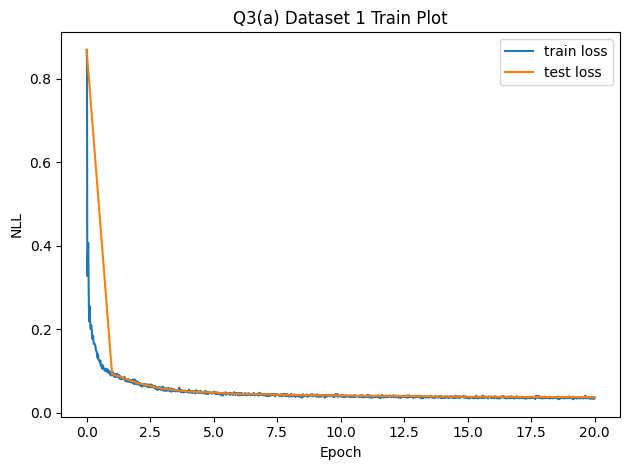

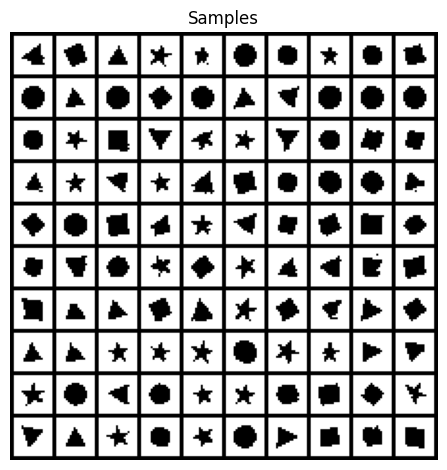

In [ ]:
q3ab_save_results(1, 'a', q3_a)

In [ ]:
q3ab_save_results(2, 'a', q3_a)

(60000, 784)


KeyboardInterrupt: 

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [ ]:
def num_To_rgb(num): 

    '''把一个数字还原成(r, g, b)'''
    values = [i for i in range(64)]
    assert num in values

    str = bin(num)[2:].zfill(6)
    r_str, g_str, b_str = str[:2], str[2: 4], str[4:]
    r, g, b = int(r_str, 2), int(g_str, 2), int(b_str, 2)

    return (r, g, b) 

NumToRGB = {i : num_To_rgb(i) for i in range(64)}
RGBToNum = {NumToRGB[i] : i for i in range(64)}


def encoding(img_data) :

    B, H, W, C = img_data.shape
    img = np.zeros((B, H, W), dtype = np.uint8)
    for i in range(B):
        for j in range(H):
            for k in range(W):
                img[i][j][k] = RGBToNum[tuple(img_data[i][j][k])]
    
    return img

def decoding(img_data) :

    B, H, W = img_data.shape
    img = np.zeros((B, H, W, 3), dtype = np.uint8)
    for i in range(B):
        for j in range(H):
            for k in range(W):
                img[i][j][k] = np.array(NumToRGB[img_data[i][j][k]])

    return img




In [ ]:
import os

def q3_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """

    H, W, C = image_shape

    train_data = encoding(train_data)
    test_data = encoding(test_data)
    
    train_data = train_data.reshape(-1, H * W)
    test_data = test_data.reshape(-1, H * W)
    
    dmodel, n_layer, n_head = 128, 2, 4
    L = H * W + 1
    vocal_size = 65
    bos = 64

    if dset_id == 1:
        lr, epoch, batch_size = 1e-3, 15, 64
    elif dset_id == 2:
        lr, epoch, batch_size = 1e-3, 15, 64


    model = iGPT(L, dmodel, vocal_size, n_layer, n_head, bos).to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr)

    train_Loader = iGPTDataLoader(train_data, batch_size, shuffle = True, num_workers = 4, bos = bos)
    test_Loader = iGPTDataLoader(test_data, batch_size, shuffle = False, num_workers = 4, bos = bos)
    schedule = CosineAnnealingLR(optimizer= optimizer, T_max=5, eta_min=3e-4)

    train_losses, test_losses, samples = [], [test_loss(model, test_Loader)], []
    
    for _ in range(epoch):
        print(f"epoch: {_}", end='         ')

        for x in train_Loader:
            
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        test_losses.append(test_loss(model, test_Loader))
        schedule.step()
        print(f"loss : {test_losses[-1]}")
    
    torch.save(model.state_dict(), os.path.join(
        'Checkpoints', 'ckpt_' + "10_new_new_" + "_.pt"))
    
    samples = model.sample(100).reshape(-1, H, W).cpu()
    print(type(samples))
    samples = samples.numpy().astype(np.uint8)
    samples = decoding(samples)

    return np.array(train_losses), np.array(test_losses), samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

<class 'torch.Tensor'>
Final Test Loss: 4.5015


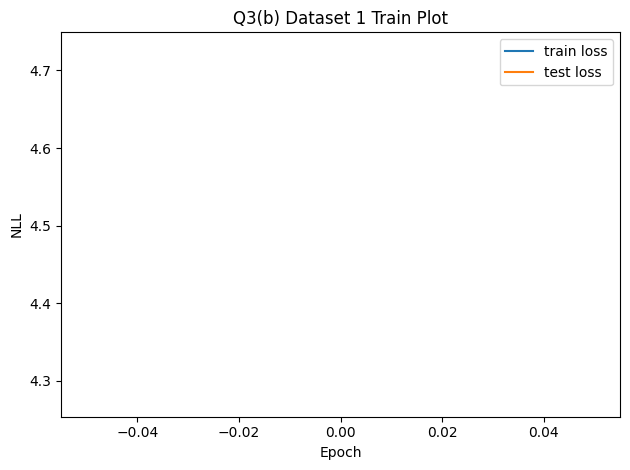

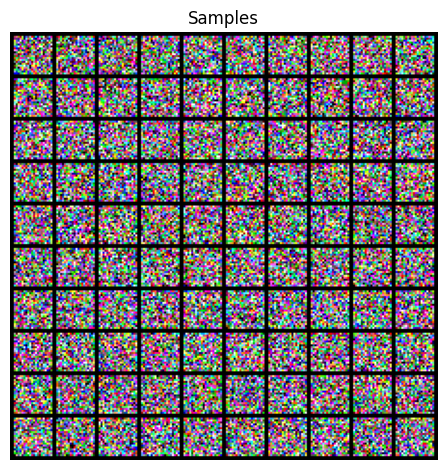

In [ ]:
q3ab_save_results(1, 'b', q3_b)

epoch: 0         loss : 0.534341470451112
epoch: 1         loss : 0.46090059086775326
epoch: 2         loss : 0.43692056920118394
epoch: 3         loss : 0.42188419373172104
epoch: 4         loss : 0.4107182367592101
epoch: 5         loss : 0.4010715596615129
epoch: 6         loss : 0.3898841571656002
epoch: 7         loss : 0.3754744189939681
epoch: 8         loss : 0.3592912457930814
epoch: 9         loss : 0.3420627722694616
epoch: 10         loss : 0.3277791337982105
epoch: 11         loss : 0.31112383752112177
epoch: 12         loss : 0.2969460935349677
epoch: 13         loss : 0.2873966179455921
epoch: 14         loss : 0.2794670597383171
<class 'torch.Tensor'>
Final Test Loss: 0.2795


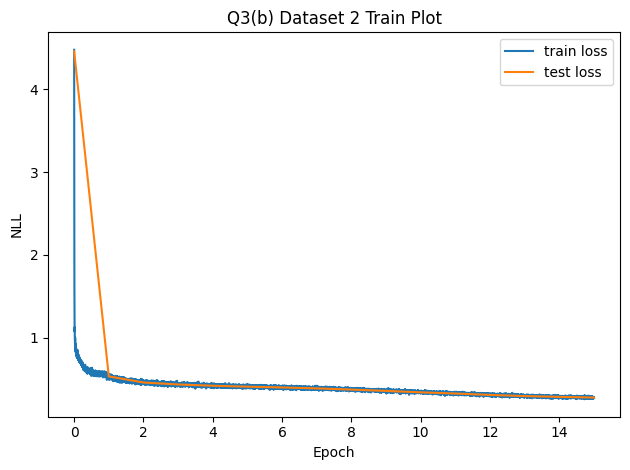

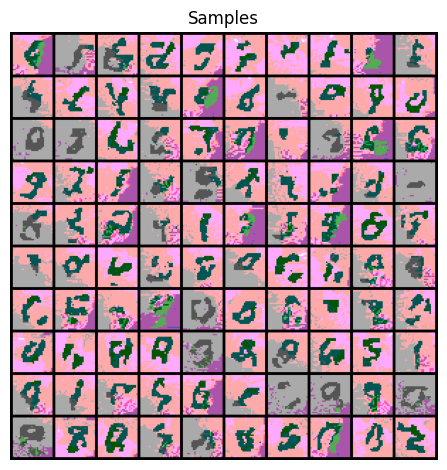

In [ ]:
q3ab_save_results(2, 'b', q3_b)

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.



In [ ]:
class CachedEmbedding(Embedding):
    def __init__(self, max_pos, vocal_size, dmodel, ):
        super().__init__(max_pos, vocal_size, dmodel)
        self.pos = 0
        self.max_pos = max_pos
        # print("Initialized CachedEmbedding")

    def forward(self, x):
        '''x (B, 1)'''
        Pos = torch.tensor(self.pos).long().to(device)
        Pos = self.embedding_pos(Pos)

        x = self.embedding(x)

        if (self.pos < self.max_pos):
            self.pos += 1
             
        return x + Pos # (B, 1, dmodel)
    
    @torch.no_grad()
    def clean_cache(self):
        self.pos = 0

class CachedAttention(Attention):
    def __init__(self, L, dmodel, dim):
        super().__init__(L, dmodel, dim)
        self.Cached_v, self.Cached_k = None, None
        # print("Initialized CachedAttention")

    def forward(self, x):
        '''x (B, 1, dmodel)'''
        q, k, v = self.q(x), self.k(x), self.v(x) # (B, 1, dim)
        if self.Cached_k == None:
            self.Cached_k = k
            self.Cached_v = v
        else:
            k = torch.cat([self.Cached_k, k], dim = 1)
            v = torch.cat([self.Cached_v, v], dim = 1)
            self.Cached_k, self.Cached_v = k, v
        
        W = q @ k.transpose(-1, -2) * self.scale # (B, 1, L)
        W = F.softmax(W, dim = -1)
        logit = W @ v
        return logit # (B, 1, dim)

    @torch.no_grad()
    def clean_cache(self):
        self.Cached_k, self.Cached_v = None, None

class CachedMutiAttention(MutiAttention):
    def __init__(self, L, dmodel, dim, n_head):
        super().__init__(L, dmodel, dim, n_head)
        self.layers = nn.ModuleList([CachedAttention(L, dmodel, dim) for _ in range(n_head)])
        # print("Initialized CachedMutiAttention")

    def forward(self, x):
        X = [layer(x) for layer in self.layers]
        return torch.cat(X, dim = -1)
    
    @torch.no_grad()
    def clean_cache(self):
        for layer in self.layers:
            layer.clean_cache()



class CachedTransformerBlock(TransformerBlock):
    def __init__(self, L, dmodel, dim, n_head):
        super().__init__(L, dmodel, dim, n_head)
        self.Attention = CachedMutiAttention(L, dmodel, dim, n_head)
        # print("Initialized CachedTransformerBlock")

    def forward(self, x):
        return super().forward(x)
    
    @torch.no_grad()
    def clean_cache(self):
        self.Attention.clean_cache()
    



class Cached_iGPT_Time(iGPT):
    def __init__(self, max_pos, dmodel, vocal_size, n_layer, n_head, bos):
        super().__init__(1, dmodel, vocal_size, n_layer, n_head, bos)
        self.embedding = CachedEmbedding(max_pos, vocal_size, dmodel)
    
        assert dmodel % n_head == 0
        self.transformer = nn.Sequential(*[CachedTransformerBlock(1, dmodel, dmodel // n_head, n_head)  for _ in range(n_layer)])
        # print("Initialized Cached_iGPT_Time")
    
    @torch.no_grad()
    def clean_cache(self):
        self.embedding.clean_cache()
        for i in self.transformer:
            i.clean_cache()

    @torch.no_grad()
    def sample(self, numbers, image_shape):
        
        H, W, C = image_shape
        samples = torch.zeros((numbers, H * W + 1), dtype = torch.long).to(device)
        samples[:, 0] = self.bos
        steps = H * W

        time_step = torch.zeros((steps), dtype = torch.float).to(device)

        self.clean_cache()
        for i in range(steps):

            time_start = time.time()
            pred = self.forward(samples[:, i].unsqueeze(-1))[:,0, :-1]
            pred = F.softmax(pred, dim = -1)
            pred = torch.multinomial(pred, 1).squeeze()

            samples[:, i + 1] = pred
            time_end = time.time()
            time_step[i] = time_end - time_start

        return samples[:, 1:], time_step


class iGPT_Time(iGPT):
    def __init__(self, L, dmodel, vocal_size, n_layer, n_head, bos):
        super().__init__(L, dmodel, vocal_size, n_layer, n_head, bos)

    @torch.no_grad()
    def sample(self, numbers, image_shape):

        H, W, C = image_shape
        samples = torch.zeros((numbers, H * W + 1)).long().to(device)
        samples[:, 0] = self.bos
        steps = H * W

        time_step = torch.zeros((steps), dtype = torch.float).to(device)
        print("--------------")
        for i in range(steps):
            
            time_start = time.time()

            pred = self.forward(samples)[:, i, : -1]
            
            pred = F.softmax(pred, dim = -1)
            pred = torch.multinomial(pred, 1).squeeze()

            samples[:, i + 1] = pred
            time_end = time.time()

            time_step[i] = time_end - time_start
        
        return samples[:, 1:], time_step







In [ ]:
'''
    In this part, we will compare the output of the two method to verify the correction
'''


l, L, vocal_size, dmodel, n_layer, n_head, bos = 1, 28 * 28 + 1, 65, 128, 2, 4, 64
batch_size = 2
dim = dmodel // n_head

torch.manual_seed(1337)
x_full = torch.randint(0, vocal_size, (batch_size, L)).to(device)

# without cache
embed = Embedding(L, vocal_size, dmodel).to(device)
x_embed_origin = embed(x_full) # (B, L, dmodel)
head = Attention(L, dmodel, dim).to(device)
y_origin = head(x_embed_origin) # (B, L, dim)

embed_state_dict, head_state_dict = embed.state_dict(), head.state_dict()

# with cache
embed_cached = CachedEmbedding(L, vocal_size, dmodel).to(device)
embed_cached.load_state_dict(embed_state_dict)

head_cached = CachedAttention(L, dmodel, dim).to(device)
head_cached.load_state_dict(head_state_dict, strict = False)

y_cached = torch.zeros(batch_size, L, dim).to(device)

for pos in range(L):
	x = x_full[:, pos].unsqueeze(1)
	x_embed_cached = embed_cached(x)
	y = head_cached(x_embed_cached)
	y_cached[:, pos, :] = y.squeeze(1)


print(torch.isclose(y_cached, y_origin, atol = 1e-6).all())

tensor(True, device='cuda:0')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# sampling steps,) numpy array of time per sampling iteration, without caching
    - a (# sampling steps,) numpy array of time per sampling iteration, with without caching
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated without caching)
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated with caching)
    """
    max_pos, vocal_size, dmodel, n_layer, n_head, bos = 28 * 28 + 1, 65, 128, 2, 4, 64

    H, W, C = image_shape
    n_samples, bos = 100, 64


    Cachedigpt = Cached_iGPT_Time(max_pos, dmodel, vocal_size, n_layer, n_head, bos).to(device)
    igpt = iGPT_Time(max_pos, dmodel, vocal_size, n_layer, n_head, bos).to(device)
    model_path = '/root/homework/Checkpoints/ckpt_10_new_new__.pt'
    load_state_dict = torch.load(model_path, map_location = device)
    current_state_dict = Cachedigpt.state_dict()

    filtered_state_dict = {k : v  for k, v in load_state_dict.items() if k in current_state_dict and current_state_dict[k].size() == v.size()}
    Cachedigpt.load_state_dict(filtered_state_dict, strict = False)
    igpt.load_state_dict(torch.load(model_path, map_location=device))

    print("-=-----")

    # without cache
    print("processing the sampling without cache")
    output, time_list_without_cache = igpt.sample(n_samples, image_shape) # (B, H*W) (B, H*W)
    samples_without_cache = output.cpu().numpy()
    samples_without_cache = samples_without_cache.reshape(n_samples, H, W).astype(np.int8) # (B, H, W)
    samples_without_cache = decoding(samples_without_cache) # (B, H, W, 3)

    # with cache
    print("processing the sampling with cache")
    output, time_list_with_cache = Cachedigpt.sample(n_samples, image_shape)
    samples_with_cache = output.cpu().numpy()
    samples_with_cache = samples_with_cache.reshape(n_samples, H, W).astype(np.int8) # (B, H, W)
    samples_with_cache = decoding(samples_with_cache) # (b, H, W, 3)
    
    '''回看time_list_without_cache才能知道，他其实是tensor'''
    return np.array(time_list_without_cache.cpu()), np.array(time_list_with_cache.cpu()), samples_without_cache, samples_with_cache

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



Initialized CachedEmbedding
Initialized CachedAttention
Initialized CachedAttention
Initialized CachedAttention
Initialized CachedAttention
Initialized CachedMutiAttention
Initialized CachedTransformerBlock
Initialized CachedAttention
Initialized CachedAttention
Initialized CachedAttention
Initialized CachedAttention
Initialized CachedMutiAttention
Initialized CachedTransformerBlock
Initialized Cached_iGPT_Time
-=-----
processing the sampling without cache
--------------


processing the sampling with cache


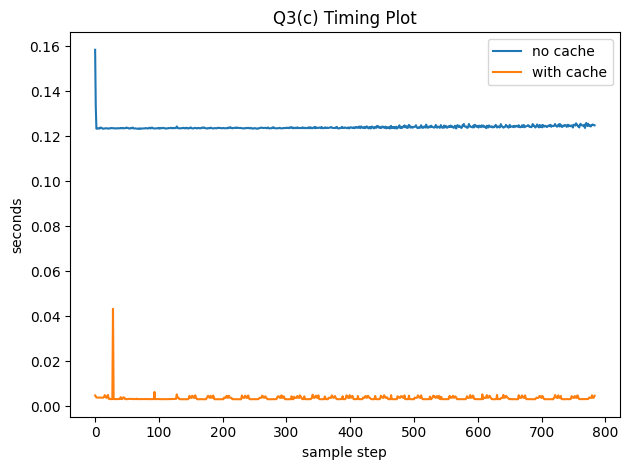

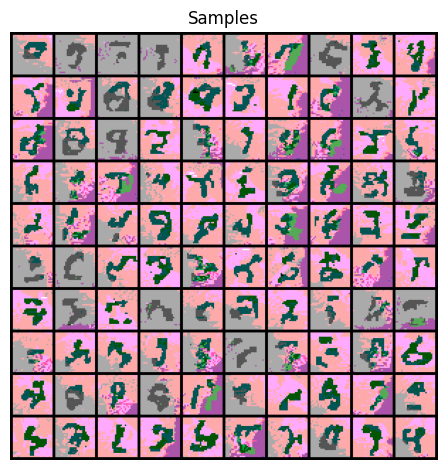

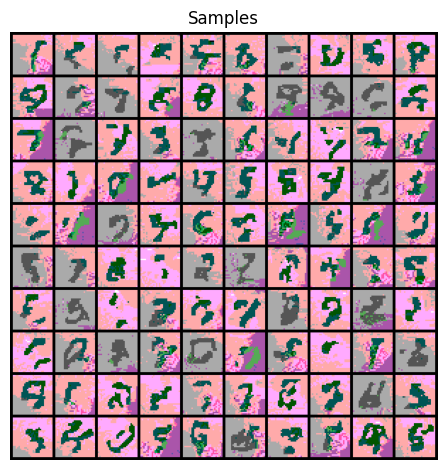

In [ ]:
q3c_save_results(2, q3_c)

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image.

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience.

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [ ]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
#

In [ ]:
def q4_a(images, vqvae):
  """
  images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a numpy array of size (2, H, W, C) of the decoded image

  """
  print(type(images))
  encoded_images = vqvae.quantize(images)
  print(type(encoded_images))
  decoded_images = vqvae.decode(encoded_images)
  
  autoencoded_images = np.array(decoded_images[:2])

  print(images.shape)
  print("vqvae.n_embeddings: ",vqvae.n_embeddings)
  return autoencoded_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06128041..1.1016654].


<class 'numpy.ndarray'>
<class 'torch.Tensor'>
(2, 28, 28, 3)
vqvae.n_embeddings:  1024


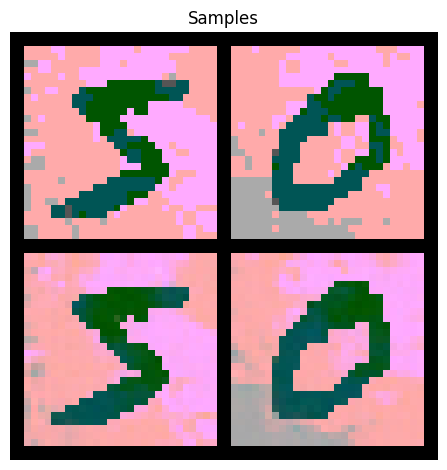

In [ ]:
q4a_save_results(1, q4_a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.084311165..1.1520307].


(2, 28, 28, 3)
vqvae.n_embeddings:  1024


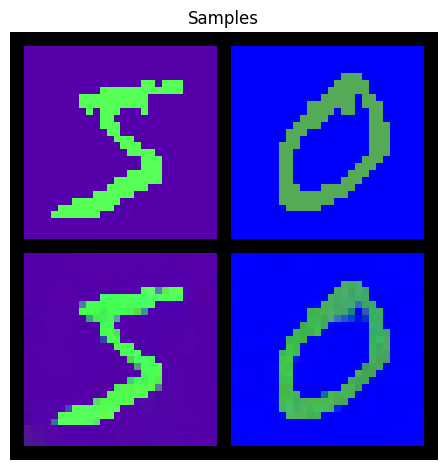

In [ ]:
q4a_save_results(2, q4_a)

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

In [ ]:
class vqvae_DataLoader(DataLoader):
	'''
        (1) quantize the image from (B, H, W, C) -> (B, 7, 7)
		(2) append the bos
	'''
	
	def __init__(self, vqvae, data, batch_size, shuffle = True, num_workers = 4, bos = 0):
		super().__init__(data, batch_size, shuffle = shuffle, num_workers = num_workers)
		self.bos = bos
		self.vqvae = vqvae

	def __iter__(self):
		for x in super().__iter__():
			B, C, W, _ = x.shape
			vec = self.vqvae.quantize(x.numpy()) # (B, 7, 7)
			vec = vec.reshape(B, 7 * 7)
			vec = append_bos(vec, self.bos)

			yield vec



In [ ]:
def q4_b(train_data, test_data, image_shape, dset_id, vqvae):
	"""
	train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
	test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
	image_shape: (H, W, C), height, width, and # of channels of the image
	dset_id: An identifying number of which dataset is given (1 or 2). Most likely
			used to set different hyperparameters for different datasets
	vqvae: a vqvae model, trained on dataset dset_id

	Returns
	- a (# of training iterations,) numpy array of train_losses evaluated every minibatch
	- a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
	- a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
	"""	
	H, W, C = image_shape
	L, vocal_size, dmodel, n_layer, n_head, bos =  7 * 7 + 1, 1024 + 1, 128, 4, 4, 1024
	
	if dset_id == 1:	
		lr, epochs, batch_size = 1e-3, 30, 128
	elif dset_id == 2:
		lr, epochs, batch_size = 1e-3, 30, 128
		
	model = iGPT(L, dmodel, vocal_size, n_layer, n_head, bos).to(device)
	optimizer = optim.Adam(model.parameters(), lr = lr)
	train_loader = vqvae_DataLoader(vqvae, train_data, batch_size, shuffle = True, num_workers = 4, bos = bos)
	test_loader = vqvae_DataLoader(vqvae, test_data, batch_size, shuffle = False, num_workers = 4, bos = bos)

	train_losses, test_losses, samples = [], [test_loss(model, test_loader)], []

	for epoch in range(epochs):
		print(f"epoch : {epoch}", end = "     ")
		for x in train_loader:
			x = x.to(device)
			optimizer.zero_grad()
			loss = model.loss(x)
			loss.backward()
			optimizer.step()
			train_losses.append(loss.item())
		
		test_losses.append(test_loss(model, test_loader))
		print(f"loss : {test_losses[-1]}")

	n_samples = 100
	samples = model.sample(n_samples).reshape(-1, 7, 7)
	samples = vqvae.decode(samples).cpu().numpy()


	return np.array(train_losses), np.array(test_losses), samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(1, q4_b)

NameError: name 'iGPT' is not defined

In [ ]:
q4b_save_results(2, q4_b)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [ ]:
data = visualize_q5_data()

Sample 1
Come live with me, and be my love,
And we will some new pleasures prove
Of golden sands, and crystal brooks,
With silken lines, and silver hooks.

There will the river whispering run
Warm'd by thy eyes, more than the sun;
And there the 'enamour'd fish will stay,
Begging themselves they may betray.

When thou wilt swim in that live bath,
Each fish, which every channel hath,
Will amorously to thee swim,
Gladder to catch thee, than thou him.

If thou, to be so seen, be'st loth,
By sun or moon, thou dark'nest both,
And if myself have leave to see,
I need not their light having thee.

Let others freeze with angling reeds,
And cut their legs with shells and weeds,
Or treacherously poor fish beset,
With strangling snare, or windowy net.

Let coarse bold hands from slimy nest
The bedded fish in banks out-wrest;
Or curious traitors, sleeve-silk flies,
Bewitch poor fishes' wand'ring eyes.

For thee, thou need'st no such deceit,
For thou thyself art thine own bait:
That fish, that is not

**Note:**
Look into the train and test data, we can see there are 83 unique characters.

In [ ]:
import deepul
from posixpath import join
def get_data_dir(hw_number: int):
    return join('deepul', 'homeworks', f'hw{hw_number}', 'data')
dir_path = get_data_dir(1)
train_data, test_data = deepul.utils.load_text_data(join(dir_path, "poetry.pkl"))
text = ''.join(train_data + test_data)
special_chars = ['<bos>', '<eos>']
chars = sorted(list(set(text)) + special_chars)
vocab_size = len(chars)
char_to_index = {ch: i for i, ch in enumerate(chars)}
index_to_char = {i: ch for ch, i in char_to_index.items()}
print(len(chars), ''.join(chars)) 
index_bos = char_to_index['<bos>']
index_eos = char_to_index['<eos>']
print(index_bos, index_eos)

85 
 !"&'(),-./0123456789:;<bos><eos>?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz{}
25 26


In [ ]:
import deepul
from posixpath import join
def get_data_dir(hw_number: int):
    return join('deepul', 'homeworks', f'hw{hw_number}', 'data')
dir_path = get_data_dir(1)
train_data, test_data = deepul.utils.load_text_data(join(dir_path, "poetry.pkl"))
print(type(train_data), train_data[1])

<class 'list'> Sir Charles into my chamber coming in,
When I was writing of my Fairy Queen;
I praysaid hewhen Queen Mab you do see
Present my service to her Majesty:
And tell her I have heard Fame's loud report
Both of her beauty and her stately court.
When I Queen Mab within my fancy viewed,
My thoughts bowed low, fearing I should be rude;
Kissing her garment thin which fancy made,
I knelt upon a thought, like one that prayed;
And then, in whispers soft, I did present
His humble service which in mirth was sent;
Thus by imagination I have been
In Fairy court and seen the Fairy Queen.


In [ ]:
x = np.array([11, 2, 3, 4])
y = np.array([5, 4, 3])
print(x, y)
np.concatenate((x, y))

[11  2  3  4] [5 4 3]


array([11,  2,  3,  4,  5,  4,  3])

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [ ]:
from torch.utils.data import Dataset

def text_preprocess(text_data, index_bos, index_eos, char_to_index):

	'''
		from [[text1], [text2], ....] to [index1, index2, ....]
	'''
	preprocessed_text = None
	
	for text in text_data :
		tokens = [index_bos] + [char_to_index[char] for char in text] + [index_eos]
		if preprocessed_text is None:
			preprocessed_text = np.array(tokens, dtype = np.uint8)
		else:
			preprocessed_text = np.concatenate((preprocessed_text, np.array(tokens, dtype = np.uint8)))
		
	return preprocessed_text

class TextDataset(Dataset):
	'''
		to get the window with the length of L 
	'''
	def __init__(self, preprocessed_text, L):
		self.data = preprocessed_text
		self.L = L
	
	def __len__(self):
		return len(self.data) - self.L + 1
	
	def __getitem__(self, index):
		return self.data[index: index + self.L]

class Embedding(nn.Module):
    def __init__(self,  L, vocal_size, dmodel):
        super().__init__()
        self.L = L
        self.vocal_size = vocal_size
        self.embedding = nn.Embedding(vocal_size, dmodel)
        self.embedding_pos = nn.Embedding(L, dmodel) #位置编码

    def forward(self, x):

        pos = torch.arange(self.L).long().to(device)
        
        pos_emb = self.embedding_pos(pos)
        
        Y = self.embedding(x) + pos_emb
 
        return Y # (B, L, dmodel)

class Attention(nn.Module):
    def __init__(self, L, dmodel, dim):
        super().__init__()
        self.q = nn.Linear(dmodel, dim)
        self.k = nn.Linear(dmodel, dim)
        self.v = nn.Linear(dmodel, dim)
        self.scale = dmodel ** (-0.5)
        self.register_buffer('tril', torch.tril(torch.ones((L, L))))

    def forward(self, x):

        ''' X : (B, L, dmodel)'''

        
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        W = q @ k.transpose(-1, -2) * self.scale # (B, L, L)
        W = W.masked_fill(self.tril == 0, float('-inf'))
        W = F.softmax(W, dim = -1)
        ans = W @ v
        return ans # (B, L, dim)


class MutiAttention(nn.Module):
    def __init__(self, L, dmodel, dim, n_head):
        super().__init__()
        self.layers = nn.ModuleList([Attention(L, dmodel, dim) for _ in range(n_head)])

    def forward(self, x):
        X = [layer(x) for layer in self.layers]
        return torch.cat(X, dim = -1) # (B, L, dim * n_head)


class TransformerBlock(nn.Module):
    def __init__(self, L, dmodel, dim, n_head):
        super().__init__()
        self.Attention = MutiAttention(L, dmodel, dim, n_head)
        self.norm1 = nn.LayerNorm(dmodel)
        self.norm2 = nn.LayerNorm(dmodel)
        self.mlp = nn.Sequential(nn.Linear(dmodel, dmodel), nn.GELU())

    def forward(self, x):

        '''X : (B, L, dmodel)'''

        x = self.Attention(self.norm1(x)) + x
        x = self.mlp(self.norm2(x)) + x
        return x  # (B, L, dmodel)


class TextGPT(nn.Module):
    def __init__(self, L, vocal_size, dmodel, n_head, n_layer, index_bos):
        super().__init__()

        self.L, self.index_bos, = L, index_bos 

        assert dmodel % n_head == 0
        self.embedding = Embedding(L, vocal_size, dmodel)
        self.Transformer = nn.Sequential(*[TransformerBlock(L, dmodel, dmodel // n_head, n_head) for _ in range(n_layer)])
        self.fc = nn.Linear(dmodel, vocal_size)
    
    def forward(self, x):
        
        ''' (B, L, dmodel) '''
        x = self.embedding(x)
        x = self.Transformer(x)
        x = self.fc(x)
        return x # (B, L, vocal_size)

    def loss(self, x):
        
        x = x.long()
        B, L = x.shape
        X = self(x)[:, : L - 1, :]
        X = X.reshape(B * (L - 1), -1)
        target = x[:, 1:].flatten()
        # print(X.dtype, target.dtype)
        # print(X.shape, target.shape)

        return F.cross_entropy(X, target)
    
    @torch.no_grad()
    def sample(self, num_samples, sentence_length):

        n_residual = sentence_length - self.L
        n1_stage = self.L if n_residual >= 0 else self.sentence_length
        samples = torch.zeros((num_samples, sentence_length + 1)) if n_residual >= 0 else torch.zeros((num_samples, self.L + 1))
        samples[:, 0] = self.index_bos
        samples = samples.long().to(device)


        for i in range(n1_stage):
            x = self(samples[:, :self.L])[:, i, :]
            x = F.softmax(x, dim = -1)
            samples[:, i + 1] = torch.multinomial(x, 1).squeeze()
        
        for i in range(1, n_residual + 1):
            
            x = self(samples[:, i: i + self.L])[:, self.L - 1, :]
            x = F.softmax(x, dim = -1)
            samples[:, i + self.L] = torch.multinomial(x, 1).squeeze()

        return samples[:, 1: sentence_length + 1]

def decode(tokens, index_to_char):
    return ''.join([index_to_char[char] for char in tokens])

def post_process(token, index_pos, index_eos, index_to_char):
    token = text[1: ] if token[0] == index_pos else token
    eoss = np.where(token == index_eos)[0]
    if eoss.size > 0:
        token = token[: eoss[0]]
        
    return decode(token, index_to_char)
	


In [ ]:
import torch.utils.data as data
import os
def q5_a(train_text, test_text):
	"""
        train_text: list[str] Train text sequences.
        test_text: list[str] Test text sequences.

        Returns
        - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
        - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
        - a list of 5 (str), 5 generated samples from the model.
    """

	start = time.time()
	text = ''.join(train_text + test_text)
	special_chars = ['<bos>', '<eos>']
	chars = sorted(list(set(text)) + special_chars)
	char_to_index = {ch : i for i, ch in enumerate(chars)}
	index_to_char = {i: ch for i, ch in enumerate(chars)}
	
	print('vocab_size:', len(chars),'\n vocabs:',''.join(chars))
	index_bos, index_eos = char_to_index['<bos>'], char_to_index['<eos>']
	print('<bos> index:', index_bos, '\t<eos> index:', index_eos)

	L, dmodel, n_head, n_layer, vocal_size = 128, 128, 4, 4, len(chars)
	batch_size, lr, epochs = 128, 3e-4, 10
	
	
	cur = time.time()

	print(f"preprocess cost: {cur - start}")
	
	train_data, test_data = text_preprocess(train_text, index_bos, index_eos, char_to_index), text_preprocess(test_text, index_bos, index_eos, char_to_index)
	train_data, test_data = TextDataset(train_data, L), TextDataset(test_data, L)
	train_loader, test_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True), DataLoader(test_data, batch_size=batch_size, shuffle=True)

	model = TextGPT(L, vocal_size, dmodel, n_head, n_layer, index_bos).to(device)
	optimizer = optim.Adam(model.parameters(), lr = lr)
	print("-----")
	train_losses, test_losses, samples = [], [test_loss(model, test_loader)], []

	# for epoch in range(epochs):
	# 	print(f"epoch : {epoch}", end = "     ")
	# 	for x in train_loader:
	# 		x = x.to(torch.int64).to(device)
	# 		optimizer.zero_grad()
	# 		loss = model.loss(x)
	# 		loss.backward()
	# 		optimizer.step()
	# 		train_losses.append(loss.item())
		
	# 	test_losses.append(test_loss(model, test_loader))
	# 	print(f"loss : {test_losses[-1]}")
		
	# torch.save(model.state_dict(), os.path.join(
    #     'Checkpoints', 'ckpt_' + "q5a" + "_.pt"))



	n_samples, len_sample = 5, 128
	samples = model.sample(n_samples, len_sample).cpu().numpy()
	text_samples = [post_process(token, index_bos, index_eos, index_to_char) for token in samples]
	end = time.time()

	print(f"training cost: {end - cur}")
	return np.array(train_losses), np.array(test_losses), text_samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



vocab_size: 85 
 vocabs: 
 !"&'(),-./0123456789:;<bos><eos>?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz{}
<bos> index: 25 	<eos> index: 26
preprocess cost: 0.016127824783325195
-----
training cost: 2.4627532958984375
Final Test Loss: 4.8489


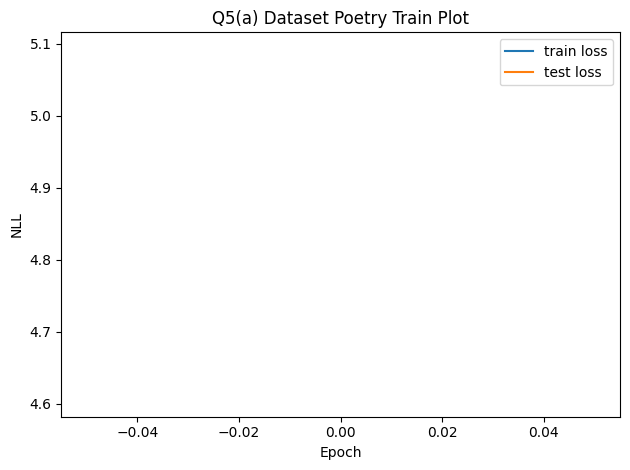

Sample 1
kK6]MXw

Sample 2
N00Wd/H]f!' :;Zf'&Fp3zfGsMdeHRq:vb&HM_mLwiR]PHM,[.Ov4:_3(m!dAWo,J)W8yC7

Sample 3
NIXT/vsxulEenpOGY'u6F5fn17

Sample 4
8T)'
R]LDKnH)v;

Sample 5
RU.Lskk,pgsiM]ymQ
CygvReuCip.m?UdrrAIfs{/]LJNP;] h Kmp
S,<bos> mmClpXrsPP;z3CmEC.M;d;]MKyc?7yBqjM]Pcf1'5CH k9J
42/



OSError: cannot open resource

In [ ]:
q5a_save_results(q5_a)

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

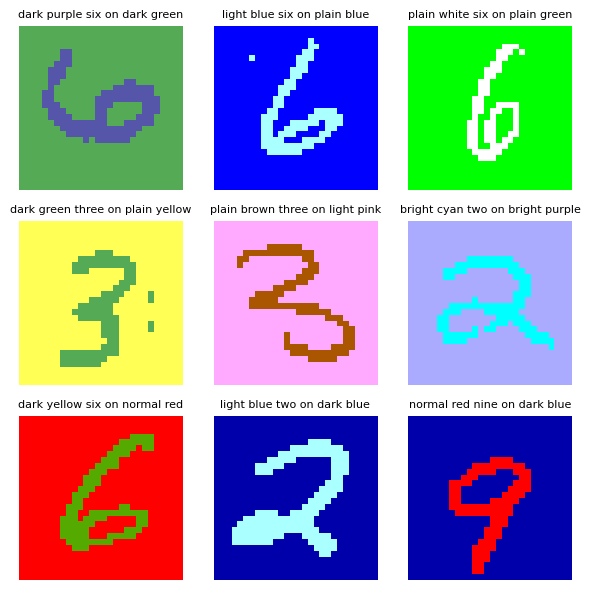

In [ ]:
visualize_q6_data()

In [ ]:
import deepul

from posixpath import join
data_dir = deepul.hw1_helper.get_data_dir(1)
train_data, test_data, train_labels, test_labels = deepul.hw1_helper.load_colored_mnist_text(
    join(data_dir, "colored_mnist_with_text.pkl")
)
print(train_data[0].shape)
print(train_labels[0])
print('All the labels has 6 words:', all([len(label.split()) == 6 for label in (train_labels + test_labels) ]))

(28, 28, 3)
light green five on dark magenta
All the labels has 6 words: True


In [ ]:
def ordered_words(train_labels, test_labels):
    '''return a list of words in the dataset'''
    words = set([word for label in (train_labels + test_labels) 
                 for word in label.split()])
    words = sorted(list(words))
    return words      

words = ordered_words(train_labels, test_labels)
print(f'There are *{len(words)}* words in the labels.')

There are *31* words in the labels.


In [ ]:
img_vocab_size = 1024
special_tokens = ['<end of text>', '<end of image>']
word_to_index = {word : i + img_vocab_size for i, word in enumerate(words + special_tokens)}
index_to_word = {i + img_vocab_size : word for i, word in enumerate(words + special_tokens)}
index_eot, index_eoi = word_to_index['<end of text>'], word_to_index['<end of image>']
vocab_size = img_vocab_size + len(words) + len(special_tokens)	
print(f'Total vocab_size: {vocab_size}')
print(f'<end of text> index: {index_eot}, <end of image> index: {index_eoi}')			
print(index_to_word[1037])													 

Total vocab_size: 1057
<end of text> index: 1055, <end of image> index: 1056
magenta


## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

In [ ]:
def pre_process(data, labels, vqvae, word_to_index):
    '''
    data: (n, H, W, C) uint8
    labels: a list of strings, each string has 6 words.
    char_to_index: a dict, mapping from char to index.

    return: 
    preprocessed_data: (n, H*W+8) int numpy Array. It's a mix of two types of sequences:
        concat([<end of image>, text_tokens, <end of text>, image_tokens]) and 
        concat([<end of text>, image_tokens, <end of image>, text_tokens]). 
        With a 50/50 split between each ordering.
    '''	

    N, H, W, _ = data.shape
    preprocessed_data = None
    batch_size = 128
    split = N // batch_size // 2
    imgloader = DataLoader(data, batch_size, shuffle = False, num_workers= 4)
    txtiter = iter(DataLoader(labels, batch_size, shuffle = False, num_workers= 4))

    for i, img in enumerate(imgloader):

        B, _, _, _ = img.shape
        labels = next(txtiter)
        img_tokens = vqvae.quantize(img.clone().detach().to(dtype = torch.float)).reshape(B, -1) # (B, 7 * 7)
        txt_tokens = [[word_to_index[word] for word in label.split()] for label in labels] # (B, 6)
        txt_tokens = torch.tensor(txt_tokens, dtype = torch.long)

        eois, eots = torch.full((B, 1), index_eoi), torch.full((B, 1), index_eot)

        if  i < split :
            tokens = torch.cat((eois, txt_tokens, eots, img_tokens), dim = 1)
        else :
            tokens = torch.cat((eots, img_tokens, eois, txt_tokens), dim = 1)

        if preprocessed_data is None :
            preprocessed_data = np.array(tokens, dtype = np.int16)
        else :
            preprocessed_data = np.concatenate((preprocessed_data, np.array(tokens, dtype = np.int16)))

    return preprocessed_data

def word_decode(tokens_arrays, index_to_word):
    '''
        Decode the (B, 6) np.array of word index to a list of strings.
    '''

    lst = []
    for array in tokens_arrays :
        string = [index_to_word[token] for token in array]
        string = ''.join(string)
        lst.append(string)
    return lst

def word_encode(lst_string, word_to_index):
    '''
        Encode the lst_string to int np.array(B, n_words)
    '''

    B = len(lst_string)
    array = None

    for i in range(B):

        words = lst_string[i].split()
        row = np.array([word_to_index[word] for word in words], dtype = np.int16)
        row = np.expand_dims(row, axis = 0)
        if array is None:
            array = row
        else:
            array = np.concatenate((array, row), axis = 0)
    return array

In [ ]:
class Embedding(nn.Module):
    def __init__(self,  L, vocal_size, dmodel):
        super().__init__()
        self.L = L
        self.vocal_size = vocal_size
        self.embedding = nn.Embedding(vocal_size, dmodel)
        self.embedding_pos = nn.Embedding(L, dmodel) #位置编码

    def forward(self, x):

        x = x.long()
        pos = torch.arange(self.L).long().to(device)
        
        pos_emb = self.embedding_pos(pos)
        
        Y = self.embedding(x) + pos_emb
 
        return Y # (B, L, dmodel)

class Attention(nn.Module):
    def __init__(self, L, dmodel, dim):
        super().__init__()
        self.q = nn.Linear(dmodel, dim)
        self.k = nn.Linear(dmodel, dim)
        self.v = nn.Linear(dmodel, dim)
        self.scale = dmodel ** (-0.5)
        self.register_buffer('tril', torch.tril(torch.ones((L, L))))

    def forward(self, x):

        ''' X : (B, L, dmodel)'''

        
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        W = q @ k.transpose(-1, -2) * self.scale # (B, L, L)
        W = W.masked_fill(self.tril == 0, float('-inf'))
        W = F.softmax(W, dim = -1)
        ans = W @ v
        return ans # (B, L, dim)


class MutiAttention(nn.Module):
    def __init__(self, L, dmodel, dim, n_head):
        super().__init__()
        self.layers = nn.ModuleList([Attention(L, dmodel, dim) for _ in range(n_head)])

    def forward(self, x):
        X = [layer(x) for layer in self.layers]
        return torch.cat(X, dim = -1) # (B, L, dim * n_head)


class TransformerBlock(nn.Module):
    def __init__(self, L, dmodel, dim, n_head):
        super().__init__()
        self.Attention = MutiAttention(L, dmodel, dim, n_head)
        self.norm1 = nn.LayerNorm(dmodel)
        self.norm2 = nn.LayerNorm(dmodel)
        self.mlp = nn.Sequential(nn.Linear(dmodel, dmodel), nn.GELU())

    def forward(self, x):

        '''X : (B, L, dmodel)'''

        x = self.Attention(self.norm1(x)) + x
        x = self.mlp(self.norm2(x)) + x
        return x  # (B, L, dmodel)


class MultiGPT(nn.Module):
    def __init__(self, L, vocal_size, dmodel, n_head, n_layer):
        super().__init__()

        self.L = L 

        assert dmodel % n_head == 0
        self.embedding = Embedding(L, vocal_size, dmodel)
        self.Transformer = nn.Sequential(*[TransformerBlock(L, dmodel, dmodel // n_head, n_head) for _ in range(n_layer)])
        self.fc = nn.Linear(dmodel, vocal_size)
    
    def forward(self, x):
        
        x = x.long()
        ''' (B, L, dmodel) '''
        x = self.embedding(x)
        x = self.Transformer(x)
        x = self.fc(x)
        return x # (B, L, vocal_size)

    def loss(self, x):
        
        x = x.long()
        B, L = x.shape
        X = self(x)[:, : L - 1, :]
        X = X.reshape(B * (L - 1), -1)
        target = x[:, 1:].flatten()
        # print(X.dtype, target.dtype)
        # print(X.shape, target.shape)

        return F.cross_entropy(X, target)
    
    @torch.no_grad()
    def sample(self, num_samples, type = 'uncond', cond_data = None):
        '''
        if sample_case='img_cond', the cond_data should be the (9, 7*7) tensor for quantized image.
        if sample_case='txt_cond', the cond_data should be the (9, 6) tensor for text
        '''
        assert type in ['img_cond', 'txt_cond', 'uncond']
        samples = torch.zeros((num_samples, self.L), dtype = torch.long).to(device)
        
        if type == 'img_cond':

            samples[:, 0] = index_eot
            samples[:, 1: 50] = cond_data
            samples[:, 50] = index_eoi

            for i in range(50, self.L - 1):
                x = self.forward(samples)[:, i, img_vocab_size: -2]
                x = F.softmax(x, dim = -1)
                samples[:, i + 1] = torch.multinomial(x, 1).squeeze() + img_vocab_size

        elif type == 'txt_cond':

            samples[:, 0] = index_eoi
            samples[:, 1: 7] = cond_data
            samples[:, 7] = index_eot

            for i in range(7, self.L - 1):
                x = self.forward(samples)[:, i, : img_vocab_size]
                x = F.softmax(x, dim = -1)
                samples[:, i + 1] = torch.multinomial(x, 1).squeeze()

        else :

            samples[:, 0] = index_eoi
            for i in range(0, 6):
                x = self.forward(samples)[:, i, img_vocab_size: -2]
                x = F.softmax(x, dim = -1)
                samples[:, i + 1] = torch.multinomial(x, 1).squeeze() + img_vocab_size
                
            samples[:, 7] = index_eot
            for i in range(7, self.L - 1):
                x = self.forward(samples)[:, i, : img_vocab_size]
                x = F.softmax(x, dim = -1)
                samples[:, i + 1] = torch.multinomial(x, 1).squeeze()

        return  samples  

In [ ]:
def q6_a(train_data, test_data, image_shape, train_text, test_text, image_test_prompt, text_test_prompt, vqvae):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
    train_text: list[str] Text data associated with each training image.
    test_text: list[str] Text data associated with each test image.
    image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
    text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
    vqvae: a vqvae model, trained on the relevant dataset

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 9 (image, text), corresponding to the image conditioned samples
    - a list of 9 (image, text), corresponding to the text conditions samples
    - a list of 9 (image, text), corresponding to unconditional samples
    """


    vqvae = deepul.hw1_helper.load_pretrain_vqvae("colored_mnist_2")
    train_data = pre_process(train_data, train_text, vqvae, word_to_index)
    test_data = pre_process(test_data, test_text, vqvae, word_to_index)

    L, dmodel, n_head, n_layer = 7 * 7 + 6 + 2, 128, 4, 8
    batch_size, lr, epochs = 128, 1e-3, 30

    train_loader = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4)
    test_loader = DataLoader(test_data, batch_size, shuffle = False, num_workers = 4)

    model = MultiGPT(L, vocab_size, dmodel, n_head, n_layer).to(device)
    model.load_state_dict(torch.load(os.path.join(
            "Checkpoints", "ckpt_q6a_.pt"), map_location=device))

    optimizer = optim.Adam(model.parameters(), lr = lr)
    train_losses, test_losses, text_samples = [], [test_loss(model, test_loader)], []

    for epoch in range(epochs):
        print(f"epoch : {epoch}", end = "     ")
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        test_losses.append(test_loss(model, test_loader))
        print(f"loss : {test_losses[-1]}")

    torch.save(model.state_dict(), os.path.join(
        'Checkpoints', 'ckpt_' + "q6a" + "_.pt"))

    n_samples = 9

    # sample for img_cond
    print("sample for img_cond")

    img_prompt_data = torch.tensor(vqvae.quantize(image_test_prompt), dtype=torch.long) # (9, 7, 7) tensor
    img_prompt_data = img_prompt_data.reshape(9, -1).to(device) # (9, 7 * 7)
    samples = model.sample(n_samples, 'img_cond', img_prompt_data).cpu().numpy() # (9, L) tensor
    images = vqvae.decode(samples[:, 1: 50].reshape(n_samples, 7, 7))
    txt = word_decode(samples[:, 51: ], index_to_word)
    samples_image_conditioned = list(zip(images, txt))

    # sample for txt_cond
    print("sample for txt_cond")

    txt_prompt_data = torch.tensor(word_encode(text_test_prompt, word_to_index), dtype = torch.long).to(device) # (9, 6)
    samples = model.sample(n_samples, 'txt_cond', txt_prompt_data).cpu().numpy() # (9, L) tensor
    images = vqvae.decode(samples[:, 8: ].reshape(n_samples, 7, 7))
    txt = word_decode(samples[:, 1: 7], index_to_word)
    samples_text_conditioned = list(zip(images, txt))

    # sample for unconditional
    print("sample for unconditional")

    samples = model.sample(n_samples).cpu().numpy()
    images = vqvae.decode(samples[:, 8: ].reshape(n_samples, 7, 7))
    txt = word_decode(samples[:, 1: 7], index_to_word)
    samples_unconditioned = list(zip(images, txt))


    return train_losses, test_losses, samples_image_conditioned, samples_text_conditioned, samples_unconditioned

In [ ]:
device = torch.device('cuda')
device

device(type='cuda')

### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



epoch : 0     loss : 2.6793111487279964
epoch : 1     loss : 2.6786598827265484
epoch : 2     loss : 2.670710056642943
epoch : 3     loss : 2.6740006404586985
epoch : 4     loss : 2.666393648220014
epoch : 5     loss : 2.6629381360886972
epoch : 6     loss : 2.664824352988714
epoch : 7     loss : 2.6614820081976394
epoch : 8     loss : 2.6581199169158936
epoch : 9     loss : 2.660557158385651
epoch : 10     loss : 2.6592583958106704
epoch : 11     loss : 2.654156597354744
epoch : 12     loss : 2.658656980417952
epoch : 13     loss : 2.656283819222752
epoch : 14     loss : 2.6564308329473567
epoch : 15     loss : 2.6569848815097084
epoch : 16     loss : 2.657110211215442
epoch : 17     loss : 2.6506597905219356
epoch : 18     loss : 2.6558874860594543
epoch : 19     loss : 2.657991967623747
epoch : 20     loss : 2.648974083646943
epoch : 21     loss : 2.6533604301983797
epoch : 22     loss : 2.6493246283712266
epoch : 23     loss : 2.652705430984497
epoch : 24     loss : 2.6533690615545

/tmp/ipykernel_56381/3755899275.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_prompt_data = torch.tensor(vqvae.quantize(image_test_prompt), dtype=torch.long) # (9, 7, 7) tensor


sample for txt_cond
sample for unconditional
Final Test Loss: 2.6550


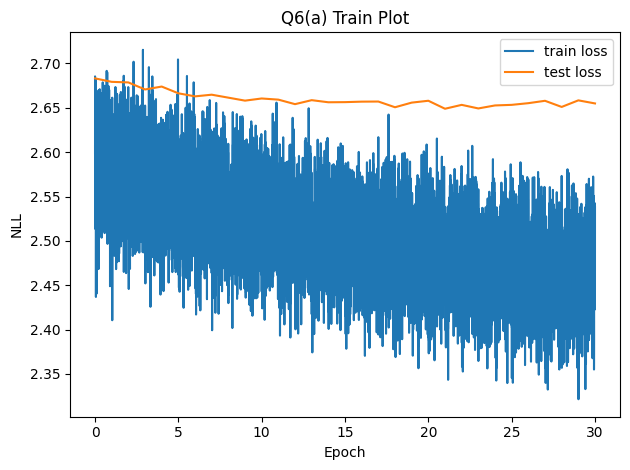

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11..272].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7..178].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5..262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-22..291].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-13..260].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-13..264].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-17..274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for fl

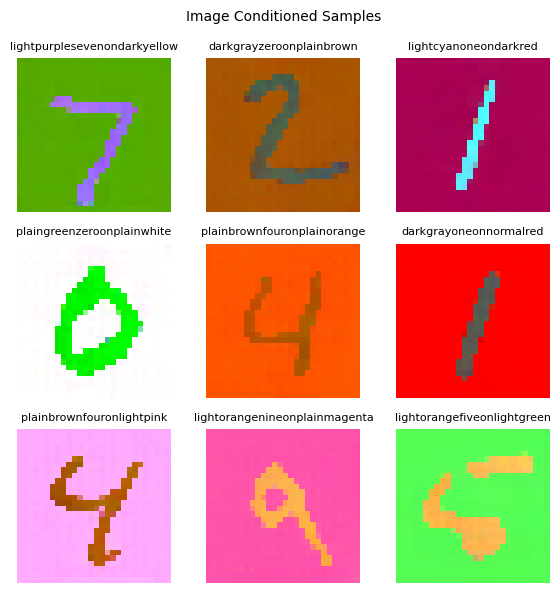

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10..279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12..182].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8..264].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-22..282].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-25..259].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9..263].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16..293].
Clipping input data to the valid range for imshow with RGB data ([0..1] for fl

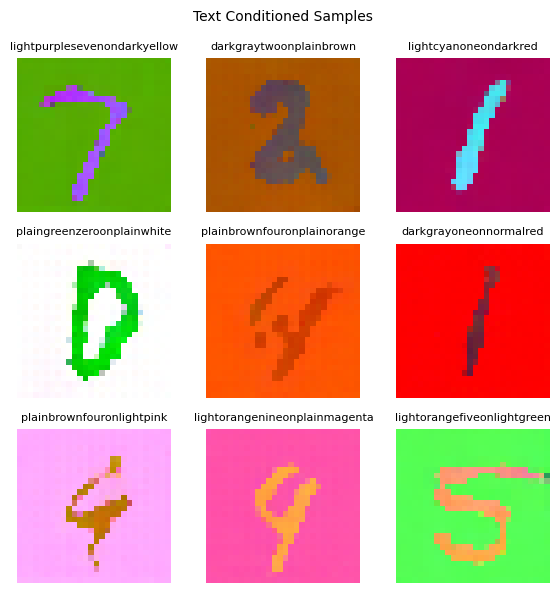

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14..262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14..194].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6..177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8..189].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-55..282].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-139..244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-20..296].
Clipping input data to the valid range for imshow with RGB data ([0..1] for f

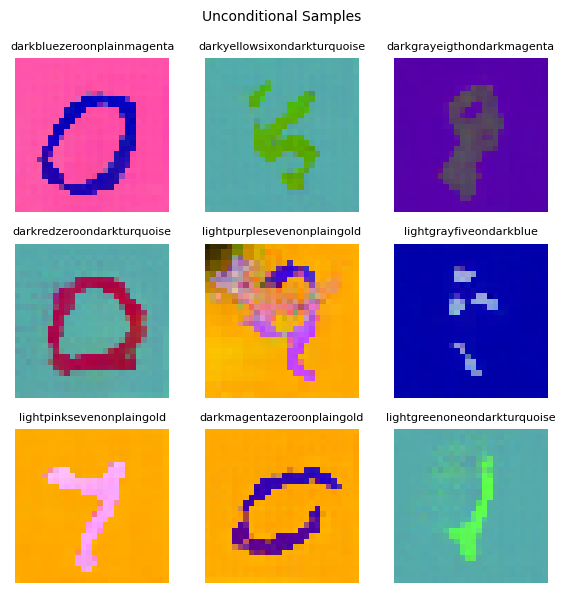

In [ ]:
q6a_save_results(q6_a)